In [21]:
import pandas as pd

# 读取原始 CSV 文件
df = pd.read_csv("transport_data/mobike_shanghai_sample_updated.csv")

# 只保留需要的列
df = df[[
    "start_time", "start_location_x", "start_location_y",
    "end_time", "end_location_x", "end_location_y"
]]


df["start_location"] = df.apply(lambda row: (row["start_location_x"], row["start_location_y"]), axis=1)
df["end_location"] = df.apply(lambda row: (row["end_location_x"], row["end_location_y"]), axis=1)

df = df[["start_time", "start_location", "end_time", "end_location"]]

# 保存结果
df.to_csv("mobike_network.csv", index=False)

print(df.head())

        start_time     start_location         end_time       end_location
0   2016/8/20 6:57  (121.348, 31.389)   2016/8/20 7:04  (121.357, 31.388)
1  2016/8/29 19:09  (121.508, 31.279)  2016/8/29 19:31  (121.489, 31.271)
2  2016/8/13 16:17  (121.383, 31.254)  2016/8/13 16:36  (121.405, 31.248)
3  2016/8/23 21:34   (121.484, 31.32)  2016/8/23 21:43  (121.471, 31.325)
4   2016/8/16 7:32  (121.407, 31.292)   2016/8/16 7:41  (121.418, 31.288)


In [27]:
import pandas as pd
import geopandas as gpd
import ast
import networkx as nx
from shapely.geometry import Point
from networkx.algorithms.community import louvain_communities

def run_louvain_from_data(trans_data, shp_path, out_path="partition.csv"):
    df = trans_data
    # 解析字符串坐标为 tuple
    def parse_loc(x):
        if isinstance(x, str):
            return tuple(ast.literal_eval(x))
        return x

    df["start_location"] = df["start_location"].apply(parse_loc)
    df["end_location"] = df["end_location"].apply(parse_loc)

    # 读取街道 shapefile
    gdf_streets = gpd.read_file(shp_path)
    # 假设街道 shapefile 的街道名称字段是 "name"（你可以改成实际字段）
    name_col = "name"

    # 构造起点/终点坐标点
    gdf_start = gpd.GeoDataFrame(
        geometry=[Point(xy) for xy in df["start_location"]],
        crs="EPSG:4326"
    )
    gdf_end = gpd.GeoDataFrame(
        geometry=[Point(xy) for xy in df["end_location"]],
        crs="EPSG:4326"
    )

    # 进行空间连接（将点匹配到街道）
    gdf_start = gpd.sjoin(gdf_start, gdf_streets, how="left", predicate="intersects")
    gdf_end = gpd.sjoin(gdf_end, gdf_streets, how="left", predicate="intersects")

    df["start_street"] = gdf_start[name_col].values
    df["end_street"] = gdf_end[name_col].values

    # 去掉匹配不到街道的记录
    df = df.dropna(subset=["start_street", "end_street"])

    # 构建街道网络（无向加权）
    G = nx.Graph()
    for _, row in df.iterrows():
        u, v = row["start_street"], row["end_street"]
        if u == v:
            continue
        if G.has_edge(u, v):
            G[u][v]["weight"] += 1
        else:
            G.add_edge(u, v, weight=1)

    print(f"图节点数: {G.number_of_nodes()}，边数: {G.number_of_edges()}")

    # 运行 Louvain 社区检测
    communities = louvain_communities(G, weight="weight", seed=42, resolution=0.5)
    partition = {node: i for i, comm in enumerate(communities) for node in comm}

    # 写出结果
    partition_df = pd.DataFrame(list(partition.items()), columns=["street", "community_id"])
    partition_df.to_csv(out_path, index=False, encoding="utf-8-sig")

    print(f"检测到 {len(communities)} 个社区。结果已保存到 {out_path}")
    return partition_df


trans_data = pd.read_csv("transport_data/mobike_network.csv")
partition_df = run_louvain_from_data(
    trans_data=trans_data,
    shp_path="transport_data/gis/上海市社区村界矢量数据.shp",
    out_path="street_partition.csv"
)

/var/folders/6r/8pf7t78x2jz69wslwjn4r2sc0000gn/T/ipykernel_66167/2681755545.py:51: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4490

  gdf_start = gpd.sjoin(gdf_start, gdf_streets, how="left", predicate="intersects")
/var/folders/6r/8pf7t78x2jz69wslwjn4r2sc0000gn/T/ipykernel_66167/2681755545.py:52: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4490

  gdf_end = gpd.sjoin(gdf_end, gdf_streets, how="left", predicate="intersects")


图节点数: 3466，边数: 47732
检测到 35 个社区。结果已保存到 street_partition.csv


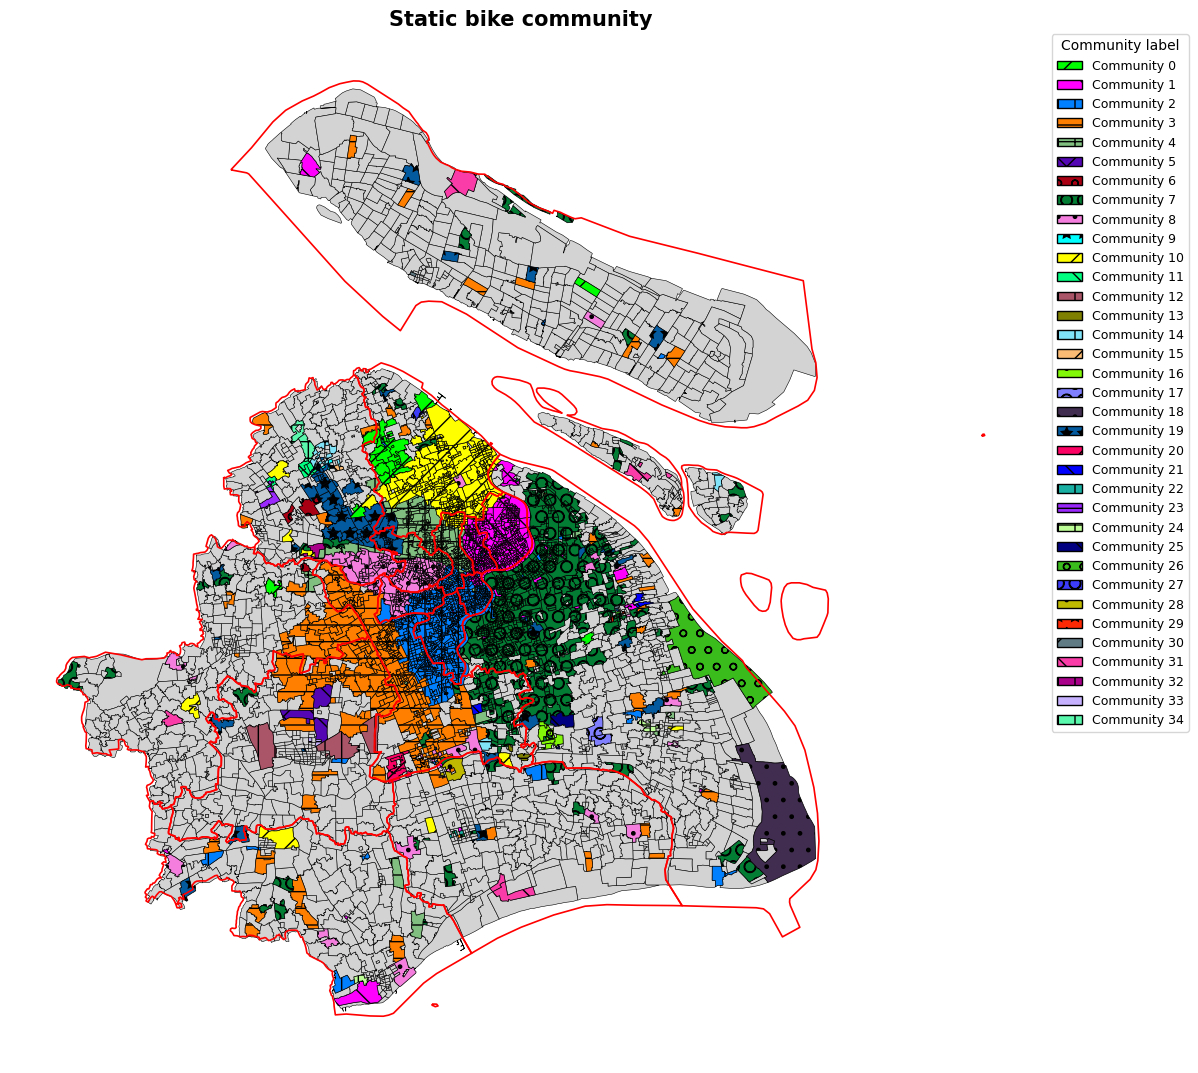

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import distinctipy
import itertools

def plot_community_map(
    streets_shp_path,              # 街道 shapefile（用于社区上色）
    partition_csv_path,            # partition.csv（street, community_id）
    districts_shp_path,            # 区级 shapefile（包含字段：Id, city, district, citycode, adcode, Shape_Leng, Shape_Area, geometry）
    out_path="community_with_districts.png",
    draw_district_labels=True      # 是否在图上标注区名
):
    # 1) 读数据
    gdf_streets = gpd.read_file(streets_shp_path)
    df_partition = pd.read_csv(partition_csv_path)
    gdf_districts = gpd.read_file(districts_shp_path)

    # 2) CRS 对齐
    if gdf_districts.crs != gdf_streets.crs:
        gdf_districts = gdf_districts.to_crs(gdf_streets.crs)

    # 3) 合并 partition
    merged = gdf_streets.merge(df_partition, how="left", left_on="name", right_on="street")

    # 4) 颜色 + 图案
    communities = sorted(merged["community_id"].dropna().unique())
    num_comms = len(communities)
    colors = distinctipy.get_colors(num_comms) if num_comms > 0 else []
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
    hatch_cycle = itertools.cycle(hatches)

    # 5) 绘图
    fig, ax = plt.subplots(figsize=(12, 12))

    # （A）先画未分配街道（灰色底+黑边）
    merged[merged["community_id"].isna()].plot(
        color="lightgray", edgecolor="black", linewidth=0.4, ax=ax, label="未分配"
    )

    legend_patches = []
    for color, cid in zip(colors, communities):
        hatch = next(hatch_cycle)
        subset = merged[merged["community_id"] == cid]
        subset.plot(
            facecolor=color,
            edgecolor="black",
            linewidth=0.5,
            hatch=hatch,
            ax=ax
        )
        legend_patches.append(
            mpatches.Patch(facecolor=color, edgecolor="black", hatch=hatch, label=f"Community {int(cid)}")
        )

    # （C）最后叠加“区级行政边界”（只画边界，不填充）
    #     注意放在最上层，线条稍粗，保证清晰
    gdf_districts.boundary.plot(ax=ax, edgecolor="red", linewidth=1.2, zorder=10)

    # （D）可选：标注区名（用代表点，避免多边形质心落在区外）
    """
    if draw_district_labels and "district" in gdf_districts.columns:
        for _, row in gdf_districts.iterrows():
            try:
                pt = row.geometry.representative_point()
                ax.text(
                    pt.x, pt.y,
                    str(row["district"]),
                    fontsize=9, fontweight="bold",
                    ha="center", va="center",
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, boxstyle="round,pad=0.2")
                )
            except Exception:
                pass
    """
    # 图例、标题等
    if legend_patches:
        ax.legend(
            handles=legend_patches,
            title="Community label",
            loc="upper left",
            bbox_to_anchor=(1.02, 1),
            borderaxespad=0,
            fontsize=9
        )
    ax.set_title("Static bike community", fontsize=15, fontweight="bold")
    ax.axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    return merged

merged_gdf = plot_community_map(
    streets_shp_path="transport_data/gis/上海市社区村界矢量数据.shp",
    partition_csv_path="street_partition.csv",
    districts_shp_path="transport_data/gis/区级数据.shp",
    out_path="community_map.png"
)

# Communities during workdays and weekends

In [41]:
import pandas as pd
import ast
import networkx as nx
from networkx.algorithms.community import louvain_communities
from datetime import datetime

def detect_weekday_weekend_communities(csv_path, shp_path):
    df = pd.read_csv(csv_path)

    def parse_loc(x):
        if isinstance(x, str):
            return tuple(ast.literal_eval(x))
        return x
    
    df["start_location"] = df["start_location"].apply(parse_loc)
    df["end_location"] = df["end_location"].apply(parse_loc)

    # 读取街道 shapefile
    gdf_streets = gpd.read_file(shp_path)
    # 假设街道 shapefile 的街道名称字段是 "name"（你可以改成实际字段）
    name_col = "name"

    # 构造起点/终点坐标点
    gdf_start = gpd.GeoDataFrame(
        geometry=[Point(xy) for xy in df["start_location"]],
        crs="EPSG:4326"
    )
    gdf_end = gpd.GeoDataFrame(
        geometry=[Point(xy) for xy in df["end_location"]],
        crs="EPSG:4326"
    )

    # 进行空间连接（将点匹配到街道）
    gdf_start = gpd.sjoin(gdf_start, gdf_streets, how="left", predicate="intersects")
    gdf_end = gpd.sjoin(gdf_end, gdf_streets, how="left", predicate="intersects")

    df["start_street"] = gdf_start[name_col].values
    df["end_street"] = gdf_end[name_col].values

    # 去掉匹配不到街道的记录
    df = df.dropna(subset=["start_street", "end_street"])


    # === 2️⃣ 时间解析 & 工作日/周末标注 ===
    df["start_time"] = pd.to_datetime(df["start_time"])
    df["weekday"] = df["start_time"].dt.weekday  # 0=Monday, 6=Sunday
    df["is_weekend"] = df["weekday"].isin([5, 6])

    # === 3️⃣ 按是否周末分组 ===
    df_weekday = df[~df["is_weekend"]].copy()
    df_weekend = df[df["is_weekend"]].copy()

    # === 4️⃣ 构建网络并运行 Louvain 社区检测 ===
    def build_graph_and_detect_community(df_subset):
        G = nx.Graph()
        for _, row in df_subset.iterrows():
            u, v = row["start_street"], row["end_street"]
            if u is None or v is None or u == v:
                continue
            if G.has_edge(u, v):
                G[u][v]["weight"] += 1
            else:
                G.add_edge(u, v, weight=1)

        if G.number_of_nodes() == 0:
            return pd.DataFrame(columns=["street", "community_id"])

        communities = louvain_communities(G, weight="weight", seed=42)
        partition = {node: i for i, comm in enumerate(communities) for node in comm}
        df_out = pd.DataFrame(list(partition.items()), columns=["street", "community_id"])
        return df_out

    df_weekday_part = build_graph_and_detect_community(df_weekday)
    df_weekend_part = build_graph_and_detect_community(df_weekend)

    # === 5️⃣ 写出结果 ===
    df_weekday_part.to_csv("partition_weekday.csv", index=False, encoding="utf-8-sig")
    df_weekend_part.to_csv("partition_weekend.csv", index=False, encoding="utf-8-sig")

    print(f"工作日：{len(df_weekday_part)} 个地点，结果已写入 partition_weekday.csv")
    print(f"周末：{len(df_weekend_part)} 个地点，结果已写入 partition_weekend.csv")

    return df_weekday_part, df_weekend_part

weekday_part, weekend_part = detect_weekday_weekend_communities("transport_data/mobike_network.csv", "transport_data/gis/上海市社区村界矢量数据.shp")

/var/folders/6r/8pf7t78x2jz69wslwjn4r2sc0000gn/T/ipykernel_66167/882318056.py:34: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4490

  gdf_start = gpd.sjoin(gdf_start, gdf_streets, how="left", predicate="intersects")
/var/folders/6r/8pf7t78x2jz69wslwjn4r2sc0000gn/T/ipykernel_66167/882318056.py:35: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4490

  gdf_end = gpd.sjoin(gdf_end, gdf_streets, how="left", predicate="intersects")


工作日：3371 个地点，结果已写入 partition_weekday.csv
周末：3108 个地点，结果已写入 partition_weekend.csv


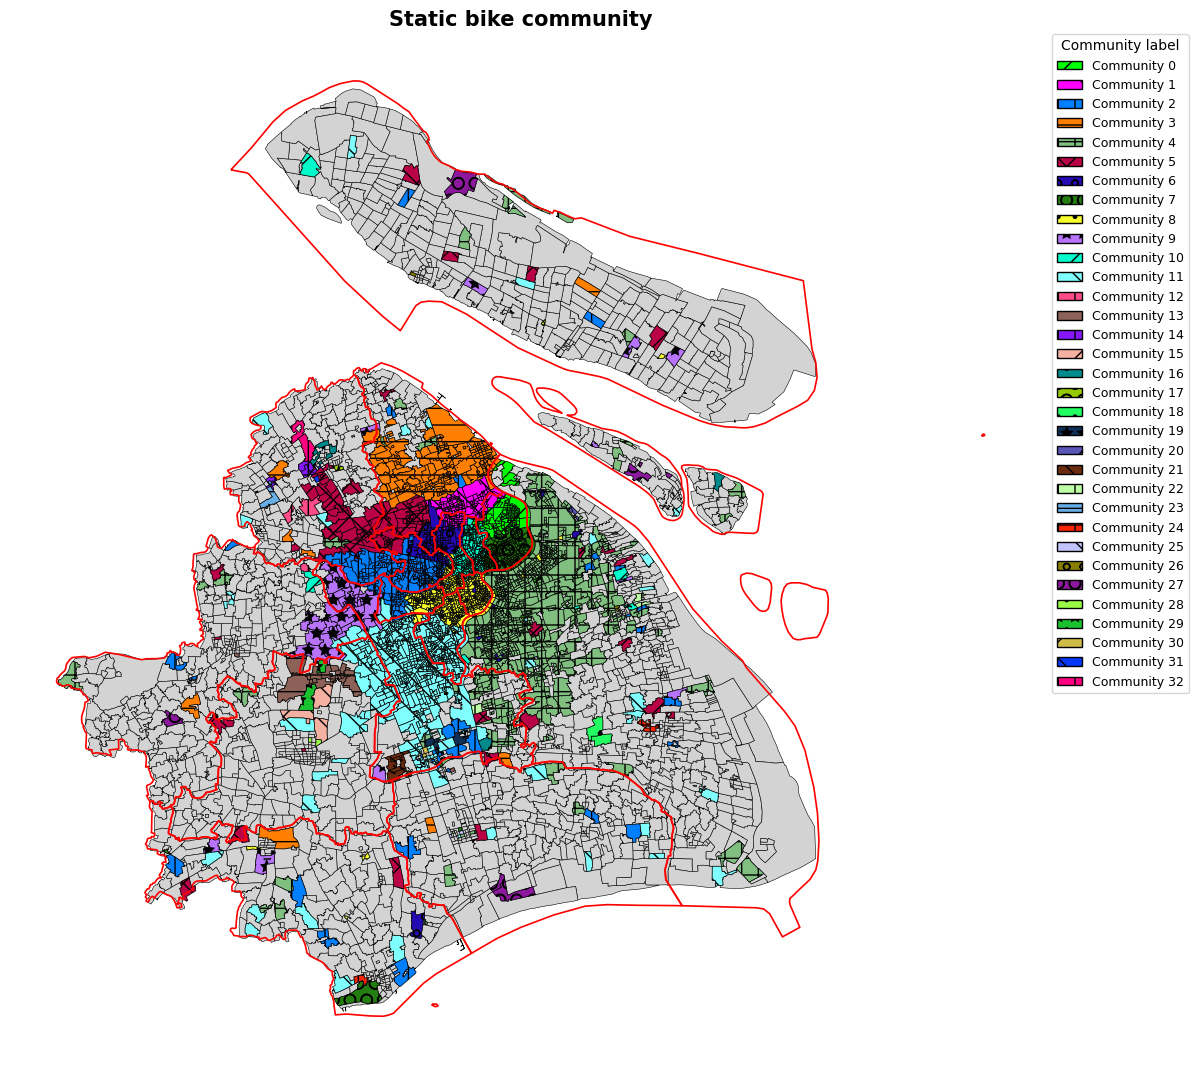

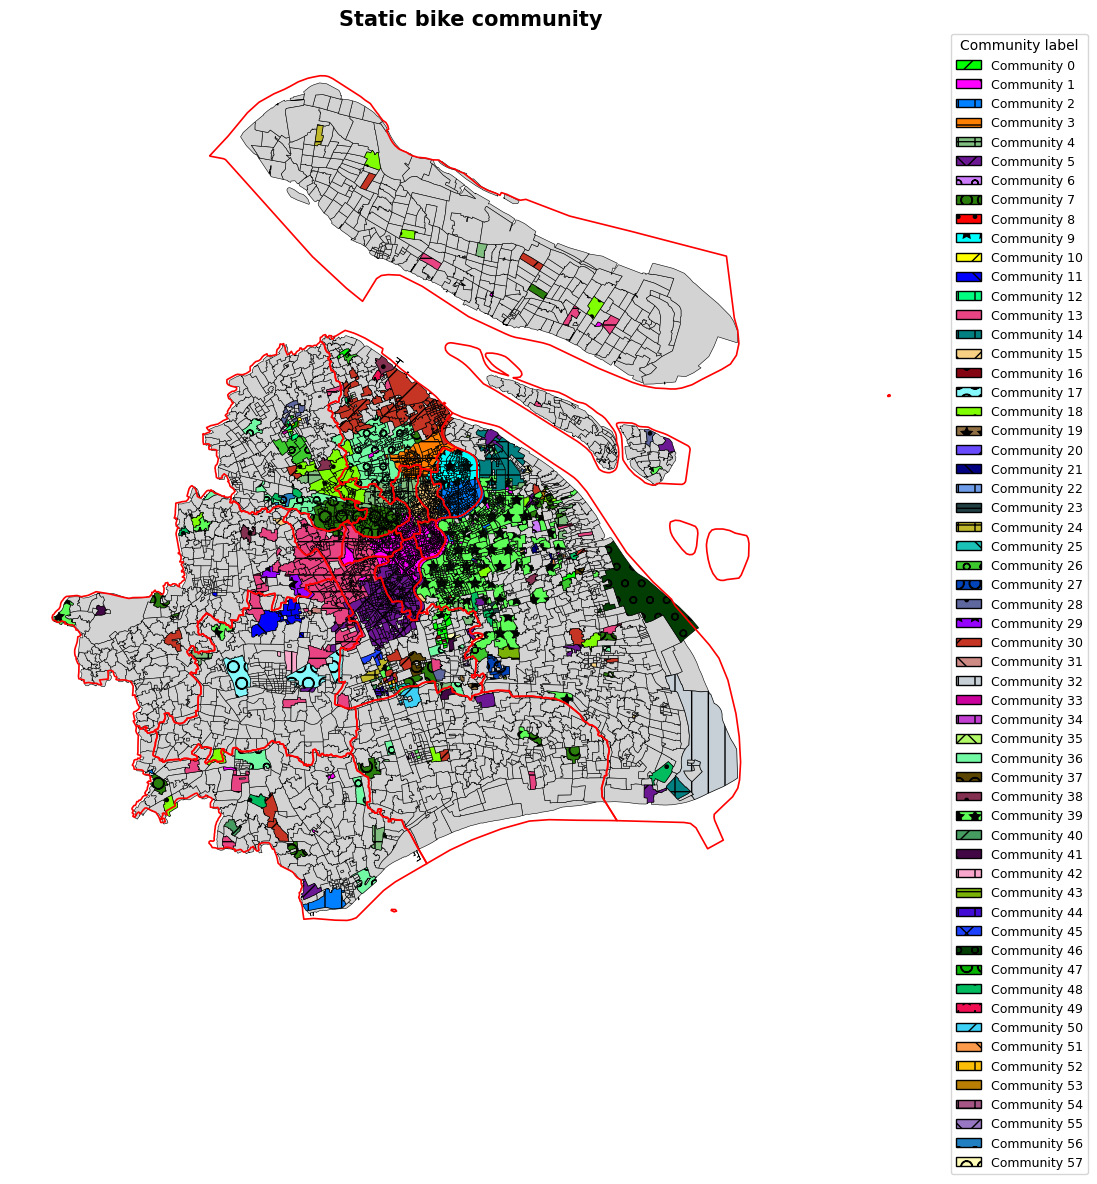

In [42]:

merged_gdf = plot_community_map(
    streets_shp_path="transport_data/gis/上海市社区村界矢量数据.shp",
    partition_csv_path="partition_weekday.csv",
    districts_shp_path="transport_data/gis/区级数据.shp",
    out_path="workday_community_map.png"
)


merged_gdf = plot_community_map(
    streets_shp_path="transport_data/gis/上海市社区村界矢量数据.shp",
    partition_csv_path="partition_weekend.csv",
    districts_shp_path="transport_data/gis/区级数据.shp",
    out_path="weekend_community_map.png"
)

# Stats on communities evolution

In [ ]:
import pandas as pd
import ast
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from networkx.algorithms.community import louvain_communities, modularity


def parse_loc(x):
    if isinstance(x, str):
        try:
            return tuple(ast.literal_eval(x))
        except Exception:
            return None
    return x


def daily_louvain_counts(csv_path, out_csv="daily_communities.csv", plot_path="daily_communities.png"):
    # 读数据
    df = pd.read_csv(csv_path)

    # 解析坐标
    df["start_location"] = df["start_location"].apply(parse_loc)
    df["end_location"] = df["end_location"].apply(parse_loc)
    df = df.dropna(subset=["start_location", "end_location"])

    # 日期字段
    df["start_time"] = pd.to_datetime(df["start_time"])
    df["date"] = df["start_time"].dt.date

    results = []
    for date, g in df.groupby("date", sort=True):
        G = nx.Graph()
        for _, row in g.iterrows():
            u, v = row["start_location"], row["end_location"]
            if not u or not v or u == v:
                continue
            if G.has_edge(u, v):
                G[u][v]["weight"] += 1
            else:
                G.add_edge(u, v, weight=1)

        n = G.number_of_nodes()
        m = G.number_of_edges()
        if n < 2:
            density = 0.0
        else:
            density = (2.0 * m) / (n * (n - 1))

        if n == 0 or m == 0:
            comm_count = 0
            mod_value = 0.0
        else:
            comms = louvain_communities(G, weight="weight", seed=42)
            comm_count = len(comms)
            mod_value = modularity(G, comms, weight="weight")

        results.append({
            "date": pd.to_datetime(date),
            "community_count": comm_count,
            "modularity": mod_value,
            "n_nodes": n,
            "n_edges": m,
            "density": density,
        })

    daily_df = pd.DataFrame(results).sort_values("date")

    # === 绘制双 y 轴图 ===
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # 左轴：社区数量
    ax1.plot(daily_df["date"], daily_df["community_count"], marker="o", color="tab:blue", label="Community Count")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Number of Communities", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # 右轴：模块度
    ax2 = ax1.twinx()
    ax2.plot(daily_df["date"], daily_df["modularity"], marker="s", color="tab:red", label="Modularity")
    ax2.set_ylabel("Modularity", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # 标题、布局
    plt.title("Daily Louvain Community Count & Modularity")
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.savefig(plot_path, dpi=300)
    plt.close()

    plt.figure(figsize=(10, 4))
    plt.plot(daily_df["date"], daily_df["density"], marker="^")
    plt.xlabel("Date")
    plt.ylabel("density")
    plt.title("Daily Network density")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("density_plot.png", dpi=300)
    plt.close()
    return daily_df


# === 使用示例 ===
daily_louvain_counts(
    "transport_data/mobike_network.csv",
    out_csv=None,
    plot_path="daily_communities.png"
)

,date,community_count,modularity,n_nodes,n_edges,density
0,2016-08-01,1057,0.997137,2865,1812,0.000442
1,2016-08-02,943,0.998093,2387,1445,0.000507
2,2016-08-03,1036,0.996921,2905,1871,0.000444
3,2016-08-04,1007,0.996800,2701,1694,0.000465
4,2016-08-05,1002,0.998124,2533,1531,0.000477
5,2016-08-06,1148,0.994190,3301,2161,0.000397
6,2016-08-07,1146,0.997347,3222,2080,0.000401
7,2016-08-08,1269,0.995799,3808,2546,0.000351
8,2016-08-09,1236,0.991606,3828,2609,0.000356
9,2016-08-10,1364,0.992917,4282,2937,0.000320
